In [1]:
#| code-fold: true
#| code-summary: "Packages and plotting settings"
#| output: false

%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from copy import deepcopy
from matplotlib.colors import Normalize
import matplotlib
from matplotlib.ticker import ScalarFormatter
import seaborn 
seaborn.set_context('talk')
# seaborn.set_context('poster')
# import scienceplots
# plt.style.use(['science','ieee'])
# plt.style.use(['science','~/.config/matplotlib/stylelib/ingo.mpl'])
# plt.style.use('~/.config/matplotlib/stylelib/ingo.mplstyle')
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

# cm = plt.get_cmap('tab20')
# cm = plt.get_cmap('Dark2')
# for color in plt.cycler("color", cm.colors):
    # print(matplotlib.colors.to_hex(color['color']))

main_dir = os.getenv("SMS")
from code_11_ijshs import *

#### Fully resolved (OpenFOAM) simulation

In [2]:
#| code-fold: true
#| code-summary: "Test: Load VTK"
#| output: false

filename = os.path.join(main_dir, "outputs/nozzle_openfoam_jonas/VTK/openfoam_0.vtk")

mesh_test, scalar_field_names = read_vtk(filename)
print(f'Available cell field: {scalar_field_names}')

Available cell field: ['cellID', 'nut', 'k', 'epsilon', 'p_rgh', 'alpha.water', 'yPlus', 'U']


In [3]:
experiments = {}

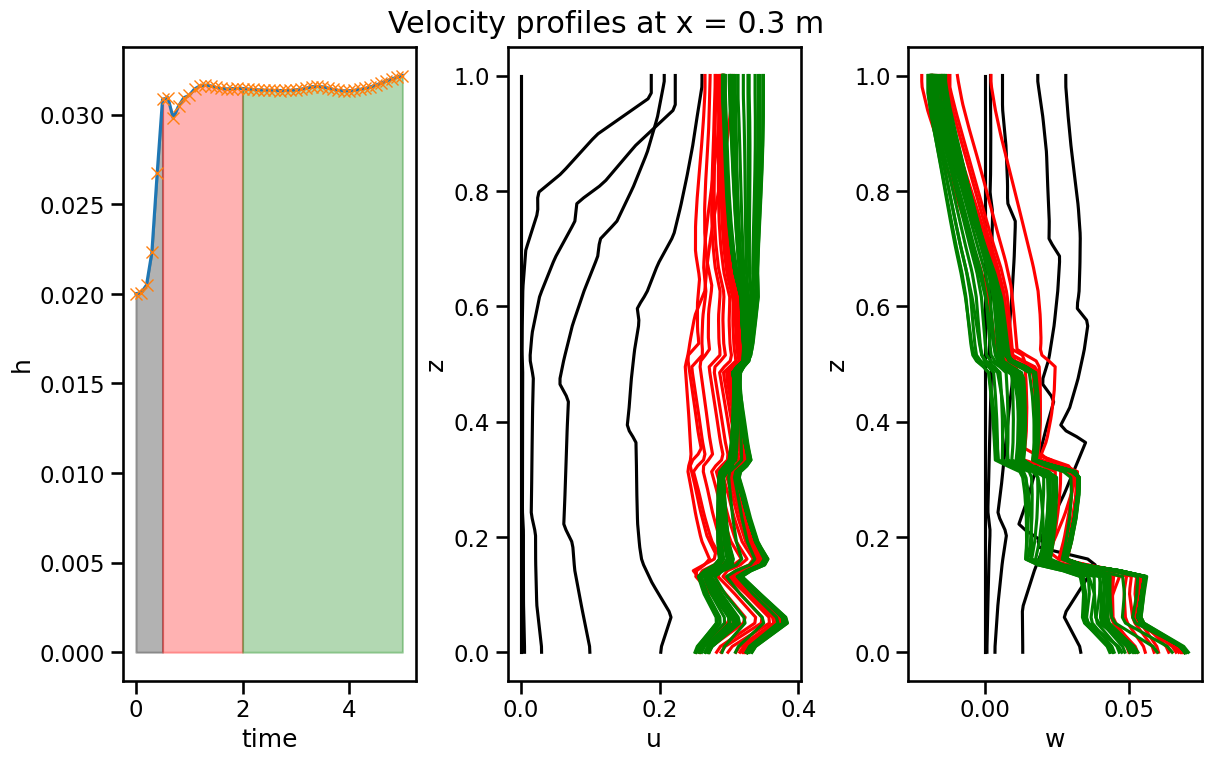

In [4]:
#| code-fold: true
#| code-summary: "Flow conditions at the beginning of the flow"
#| output: false

directory = os.path.join(main_dir, 'outputs/nozzle_openfoam_jonas/VTK')
pos, h, u, w, iteration = extract_1d_data(directory, pos=[0.3, 0, 0], stride=10)

fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(12,7.5))
fig.suptitle(f'Velocity profiles at x = {0.3} m')
ax[0].set_xlabel('time')
ax[0].set_ylabel('h')
ax[1].set_xlabel('u')
ax[1].set_ylabel('z')
ax[2].set_xlabel('w')
ax[2].set_ylabel('z')

z = np.linspace(0, 1, 100)
dt = 0.01
time = dt * iteration

regions = [0,5,20,1000]
ax[0].plot(time, h)
ax[0].plot(time, h, 'x')
ax[0].fill_between(time[regions[0]:regions[1]+1], h[regions[0]:regions[1]+1], color='k', alpha=0.3)
ax[0].fill_between(time[regions[1]:regions[2]+1], h[regions[1]:regions[2]+1], color='r', alpha=0.3)
ax[0].fill_between(time[regions[2]:regions[3]+1], h[regions[2]:regions[3]+1], color='g', alpha=0.3)
for i in range(u.shape[0]):
    if i >= regions[0] and i < regions[1]:
        ax[1].plot(u[i], z, 'k')
        ax[2].plot(w[i], z, 'k')
    elif i >= regions[1] and i < regions[2]:
        ax[1].plot(u[i], z, 'r')
        ax[2].plot(w[i], z, 'r')
    elif i >= regions[2] and i <= regions[3]:
        ax[1].plot(u[i], z, 'g')
        ax[2].plot(w[i], z, 'g')

experiments["0.3"] = {"pos": pos.copy(), "h": h.copy(), "u":u.copy(), "w": w.copy(), "timeline":time}
fig.savefig('images/VP03.png')

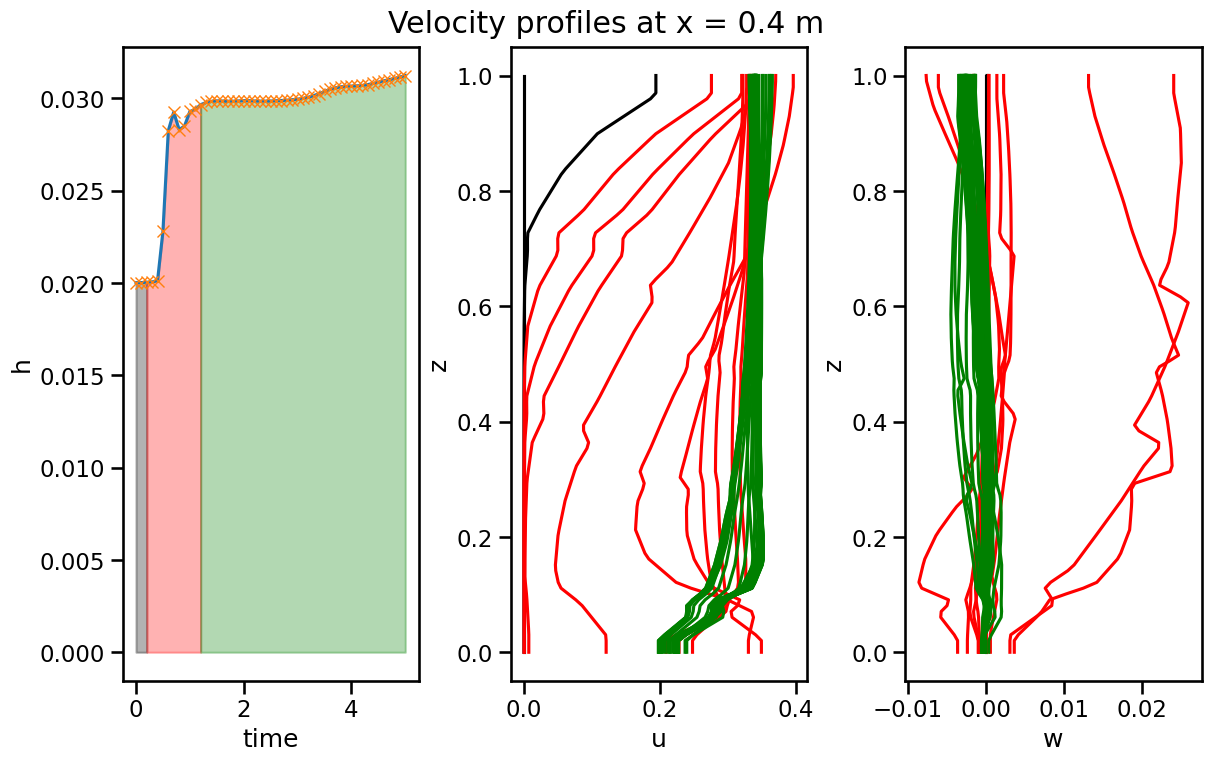

In [5]:
#| code-fold: true
#| code-summary: "Flow conditions at the beginning of the flow"
#| output: false

directory = os.path.join(main_dir, 'outputs/nozzle_openfoam_jonas/VTK')
pos, h, u, w, iteration = extract_1d_data(directory, pos=[0.4, 0, 0], stride=10)

fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(12,7.5))
fig.suptitle(f'Velocity profiles at x = {0.4} m')
ax[0].set_xlabel('time')
ax[0].set_ylabel('h')
ax[1].set_xlabel('u')
ax[1].set_ylabel('z')
ax[2].set_xlabel('w')
ax[2].set_ylabel('z')

z = np.linspace(0, 1, 100)
dt = 0.01
time = dt * iteration

regions = [0, 2, 12, 1000]
ax[0].plot(time, h)
ax[0].plot(time, h, 'x')
ax[0].fill_between(time[regions[0]:regions[1]+1], h[regions[0]:regions[1]+1], color='k', alpha=0.3)
ax[0].fill_between(time[regions[1]:regions[2]+1], h[regions[1]:regions[2]+1], color='r', alpha=0.3)
ax[0].fill_between(time[regions[2]:regions[3]+1], h[regions[2]:regions[3]+1], color='g', alpha=0.3)
for i in range(u.shape[0]):
    if i >= regions[0] and i < regions[1]:
        ax[1].plot(u[i], z, 'k')
        ax[2].plot(w[i], z, 'k')
    elif i >= regions[1] and i < regions[2]:
        ax[1].plot(u[i], z, 'r')
        ax[2].plot(w[i], z, 'r')
    elif i >= regions[2] and i <= regions[3]:
        ax[1].plot(u[i], z, 'g')
        ax[2].plot(w[i], z, 'g')
experiments["0.4"] = {"pos": pos.copy(), "h": h.copy(), "u":u.copy(), "w": w.copy(), "timeline":time}
fig.savefig('images/VP04.png')

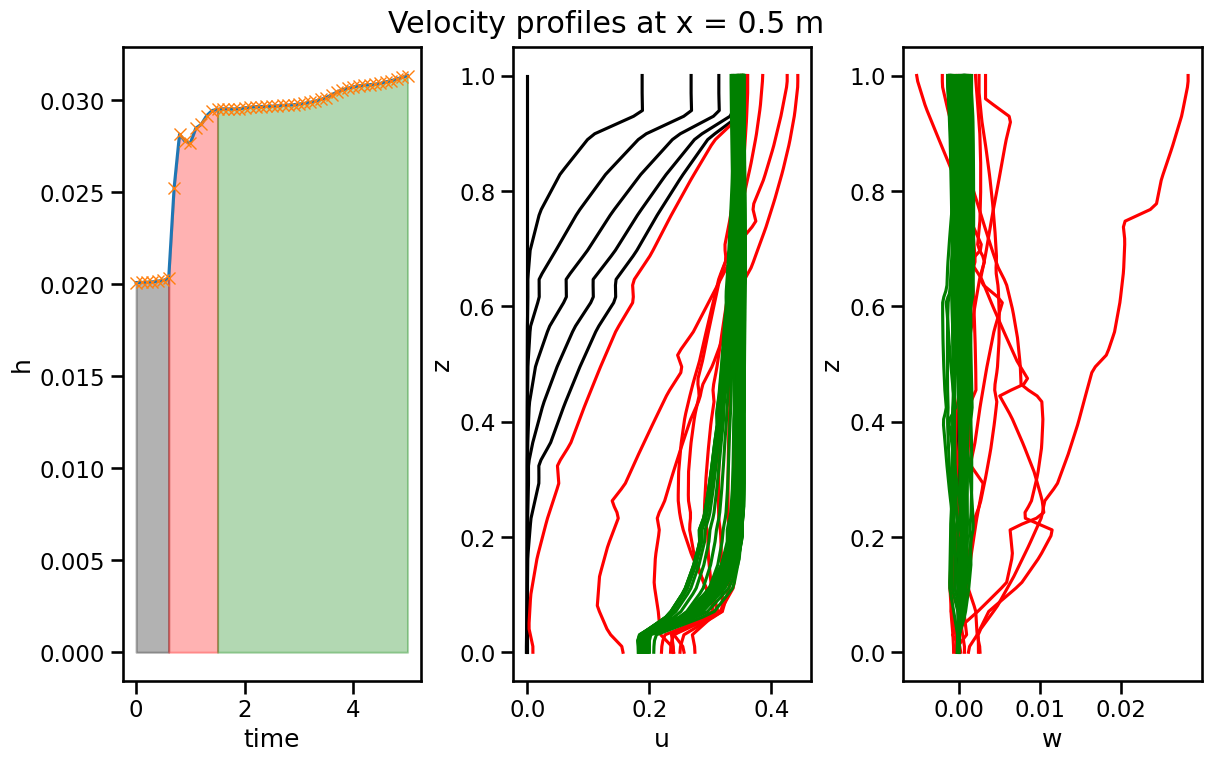

In [6]:
#| code-fold: true
#| code-summary: "Flow conditions at the beginning of the flow"
#| output: false

directory = os.path.join(main_dir, 'outputs/nozzle_openfoam_jonas/VTK')
pos, h, u, w, iteration = extract_1d_data(directory, pos=[0.5, 0, 0], stride=10)

fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(12,7.5))
fig.suptitle(f'Velocity profiles at x = {0.5} m')
ax[0].set_xlabel('time')
ax[0].set_ylabel('h')
ax[1].set_xlabel('u')
ax[1].set_ylabel('z')
ax[2].set_xlabel('w')
ax[2].set_ylabel('z')

z = np.linspace(0, 1, 100)
dt = 0.01
time = dt * iteration

regions = [0, 6, 15, 1000]
ax[0].plot(time, h)
ax[0].plot(time, h, 'x')
ax[0].fill_between(time[regions[0]:regions[1]+1], h[regions[0]:regions[1]+1], color='k', alpha=0.3)
ax[0].fill_between(time[regions[1]:regions[2]+1], h[regions[1]:regions[2]+1], color='r', alpha=0.3)
ax[0].fill_between(time[regions[2]:regions[3]+1], h[regions[2]:regions[3]+1], color='g', alpha=0.3)
for i in range(u.shape[0]):
    if i >= regions[0] and i < regions[1]:
        ax[1].plot(u[i], z, 'k')
        ax[2].plot(w[i], z, 'k')
    elif i >= regions[1] and i < regions[2]:
        ax[1].plot(u[i], z, 'r')
        ax[2].plot(w[i], z, 'r')
    elif i >= regions[2] and i <= regions[3]:
        ax[1].plot(u[i], z, 'g')
        ax[2].plot(w[i], z, 'g')
experiments["0.5"] = {"pos": pos.copy(), "h": h.copy(), "u":u.copy(), "w": w.copy(), "timeline":time}
fig.savefig('images/VP05.png')

[1, 1 - 2*x, 3*(2*x - 1)**2/2 - 1/2, 3*x - 5*(2*x - 1)**3/2 - 3/2, 35*(2*x - 1)**4/8 - 15*(2*x - 1)**2/4 + 3/8, -15*x/4 - 63*(2*x - 1)**5/8 + 35*(2*x - 1)**3/4 + 15/8, 231*(2*x - 1)**6/16 - 315*(2*x - 1)**4/16 + 105*(2*x - 1)**2/16 - 5/16, 35*x/8 - 429*(2*x - 1)**7/16 + 693*(2*x - 1)**5/16 - 315*(2*x - 1)**3/16 - 35/16, 6435*(2*x - 1)**8/128 - 3003*(2*x - 1)**6/32 + 3465*(2*x - 1)**4/64 - 315*(2*x - 1)**2/32 + 35/128]
Moments: [ 3.05487964e-01 -5.74141818e-02 -3.50193746e-02 -2.25594841e-02
 -1.54886343e-02 -8.52799840e-03 -3.82920364e-03  2.45948703e-04
  3.08866587e-03]
errors: [0.0014573267648598073, 0.0003583956009167614, 0.00011302511926271653, 4.039681021874431e-05, 1.3902503566941499e-05, 7.476433479946687e-06, 6.466901958146385e-06, 6.4534956645472134e-06, 5.772271213148068e-06]
relative errors: [1.0, 4.066251820982246, 12.893830808285943, 36.075292998841796, 104.8247718723955, 194.9227220129295, 225.35160951744544, 225.81974802675498, 252.47025149135598]


/home/ingo/Git/SMM/shallow-moments-simulation/docs/problems/code_11_ijshs.py:135: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  nominator, error = quad(lambda z: u_spline(z) * b(z), z[0], z[-1])


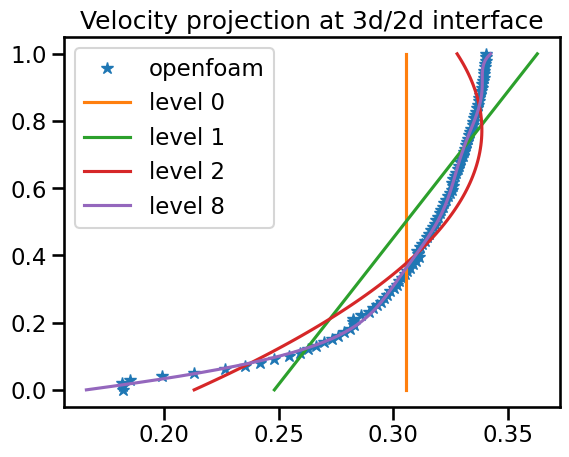

In [7]:
from library.model.model import *
level = 8
basis_analytical =Legendre_shifted(order=level+1)
basis_readable = [basis_analytical.get(k) for k in range(level+1)]
basis = [basis_analytical.get_lambda(k) for k in range(level+1)]
print(basis_readable)

u_test = u[-1]
moments = project_to_smm(u_test, z, basis=basis)
print(f'Moments: {moments}')
reconstructions = []
for k in range(level+1):
    reconst = moments[0] * basis[0](z)
    for i in range(1,k+1):
        reconst += moments[i] * basis[i](z)
    reconstructions.append(reconst)

errors = []
rel_errors = []
error_0 = np.trapz((u_test - reconstructions[0])**2, z)
for k in range(level+1):
    error = np.trapz((u_test - reconstructions[k])**2, z)
    errors.append(error)
    rel_errors.append(error_0/error)


fig, ax = plt.subplots()
plt.plot(u_test, z, '*', label='openfoam')
# for k in range(level+1):
#     ax.plot(reconstructions[k], z, label=f'level {k}')

for k in [0, 1, 2, 8]:
    ax.plot(reconstructions[k], z, label=f'level {k}')

plt.title('Velocity projection at 3d/2d interface')
plt.legend()

print(f'errors: {errors}')
print(f'relative errors: {rel_errors}')
fig.savefig('images/ProjectionInflow.png')

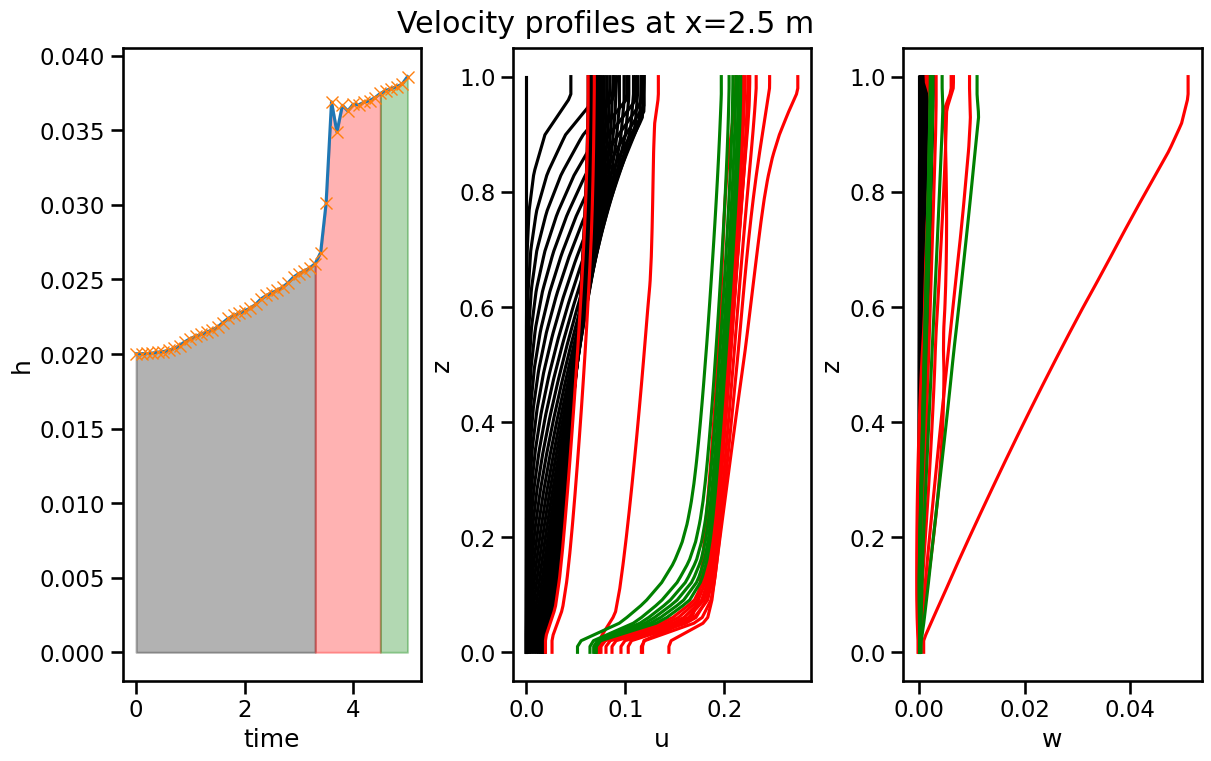

In [8]:
#| code-fold: true
#| code-summary: "Flow conditons at the end of the channel"
#| output: true

directory = os.path.join(main_dir, 'outputs/nozzle_openfoam_jonas/VTK')
pos, h, u, w, iteration = extract_1d_data(directory, pos=[2.5, 0, 0], stride=10)

fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(12,7.5))
fig.suptitle(f'Velocity profiles at x={2.5} m')
ax[0].set_xlabel('time')
ax[0].set_ylabel('h')
ax[1].set_xlabel('u')
ax[1].set_ylabel('z')
ax[2].set_xlabel('w')
ax[2].set_ylabel('z')

z = np.linspace(0, 1, 100)
dt = 0.01
time = dt * iteration

regions = [0, 33, 45, 1000]
ax[0].plot(time, h)
ax[0].plot(time, h, 'x')
ax[0].fill_between(time[regions[0]:regions[1]+1], h[regions[0]:regions[1]+1], color='k', alpha=0.3)
ax[0].fill_between(time[regions[1]:regions[2]+1], h[regions[1]:regions[2]+1], color='r', alpha=0.3)
ax[0].fill_between(time[regions[2]:regions[3]+1], h[regions[2]:regions[3]+1], color='g', alpha=0.3)
for i in range(u.shape[0]):
    if i >= regions[0] and i < regions[1]:
        ax[1].plot(u[i], z, 'k')
        ax[2].plot(w[i], z, 'k')
    elif i >= regions[1] and i < regions[2]:
        ax[1].plot(u[i], z, 'r')
        ax[2].plot(w[i], z, 'r')
    elif i >= regions[2] and i <= regions[3]:
        ax[1].plot(u[i], z, 'g')
        ax[2].plot(w[i], z, 'g')
experiments["2.5"] = {"pos": pos.copy(), "h": h.copy(), "u":u.copy(), "w": w.copy(), "timeline":time}
fig.savefig('images/VP25.png')

#### Depth-averaged (Shallow Moment) simulation

In [9]:
#| code-fold: true
#| code-summary: "Imports"

import numpy as np
import pytest
from types import SimpleNamespace

from library.model.model import *
from library.pysolver.solver import *
import library.model.initial_conditions as IC
import library.model.boundary_conditions as BC
from library.pysolver.ode import RK1
import library.misc.io as io
from library.pysolver.reconstruction import GradientMesh
import library.mesh.mesh as petscMesh
import library.postprocessing.postprocessing as postprocessing
import argparse


In [12]:
#| code-fold: true
#| code-summary: "Mesh"
#| output: false
mesh = petscMesh.Mesh.create_1d((0.5, 3.0), 100)


In [13]:
#| code-summary: "Generate boundary data"
#| code-fold: true
#| output: false 

def project_openfoam_to_smm(directory, pos=[0.5, 0, 0], stride=60, dt=0.01, level=10, output_uw=False):
    pos, h, u, w, iteration = extract_1d_data(directory, pos=pos, stride=stride)
    iteration_times = dt * iteration
    basis_analytical =Legendre_shifted(order=level+1)
    basis = [basis_analytical.get_lambda(k) for k in range(level+1)]

    moments = []
    moments_w = []
    z = np.linspace(0, 1, u.shape[1])
    for u_n in u:
        moments.append(project_to_smm(u_n, z, basis=basis))
    for w_n in w:
        moments_w.append(project_to_smm(w_n, z, basis=basis))
    moments = np.array(moments)
    moments_w = np.array(moments_w)
    if output_uw:
        return h, moments, moments_w, iteration_times, u, w
    return h, moments, moments_w, iteration_times

def shear_at_bottom_moments(moments):
    level = moments.shape[1]-1
    basis_analytical =Legendre_shifted(order=level)
    basis_analytical.get_diff_basis()
    basis_0 = np.array([basis_analytical.eval(k, 0) for k in range(level+1)], dtype=float)

    shear =  np.zeros(moments.shape[0], dtype=float)
    for i in range(level+1):
        shear += moments[:, i] * basis_0[i]

    return shear


In [14]:

h_inflow ,moments_inflow, moments_w_inflow, timeline_inflow, u_inflow, w_inflow = project_openfoam_to_smm(directory, pos=[0.5, 0, 0], stride=60, output_uw=True)

inflow moments: [ 9.32996640e-03 -8.60852991e-04 -9.95831590e-05 -2.61356400e-04
 -5.97143364e-04 -5.18587460e-04 -2.98802981e-04 -1.51129616e-04
 -2.82794877e-05  1.38287758e-04  2.12297731e-04]
errors: [0.00041345472630068746, 0.00011320038673119802, 0.00011078927769778469, 9.894166168968568e-05, 5.08671154220034e-05, 2.144687784518934e-05, 1.3441269343900157e-05, 1.185808754459731e-05, 1.1859954827605148e-05]
relative errors: [1.0, 3.6524144328452133, 3.731901993517147, 4.178772816626231, 8.12813392052188, 19.278084637080532, 30.760095324502906, 34.866897781427035, 34.86140818499014]


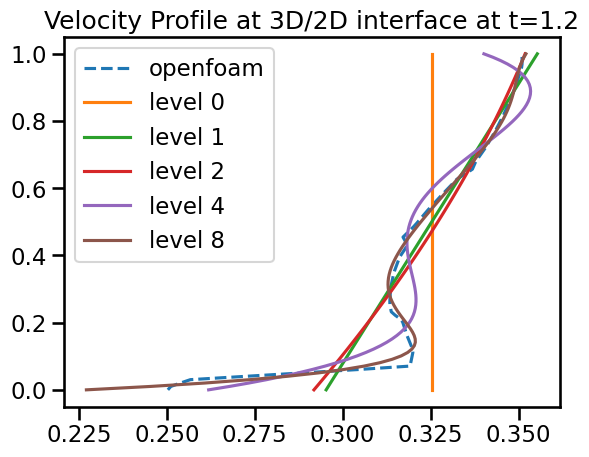

In [15]:
from library.model.model import *

h_inflow ,moments_inflow, moments_w_inflow, timeline_inflow, u_inflow, w_inflow = project_openfoam_to_smm(directory, pos=[0.5, 0, 0], stride=60, output_uw=True)
level = 8
basis_analytical =Legendre_shifted(order=level+1)
basis_readable = [basis_analytical.get(k) for k in range(level+1)]
basis = [basis_analytical.get_lambda(k) for k in range(level+1)]

i_time = 2
moments = moments_inflow[i_time]
print(f'inflow moments: {moments * h_inflow[i_time]}')

reconstructions = []
for k in range(level+1):
    reconst = moments[0] * basis[0](z)
    for i in range(1,k+1):
        reconst += moments[i] * basis[i](z)
    reconstructions.append(reconst)

errors = []
rel_errors = []
error_0 = np.trapz((u_inflow[i_time] - reconstructions[0])**2, z)
for k in range(level+1):
    error = np.trapz((u_inflow[i_time] - reconstructions[k])**2, z)
    errors.append(error)
    rel_errors.append(error_0/error)


fig, ax = plt.subplots()
plt.plot(u_inflow[i_time], z, '--', label='openfoam')
# for k in range(level+1):
#     ax.plot(reconstructions[k], z, label=f'level {k}')

for k in [0, 1, 2, 4, 8]:
    ax.plot(reconstructions[k], z, label=f'level {k}')

plt.legend()

print(f'errors: {errors}')
print(f'relative errors: {rel_errors}')
plt.title(f"Velocity Profile at 3D/2D interface at t={60 * 2 * dt}")
fig.savefig("images/VP_inflow2.png")

In [80]:
#| code-summary: "Model"
#| code-fold: true
level = 2
offset = level+1

data_dict = {}
data_dict[0] = h_inflow 
for i in range(level+1):
    data_dict[1+i] = h_inflow * moments_inflow[:, i]
# data_dict[1] = h_inflow * np.sqrt((moments_inflow[:, 0]**2 + moments_w_inflow[:, 0]**2))
# data_dict[2] = h_inflow * moments_inflow[:, 1]
# for i in range(2, level+1):
#     data_dict[i] = np.zeros_like(h_inflow)

bcs = BC.BoundaryConditions(
    [
        BC.FromData(physical_tag='left', prescribe_fields=data_dict, timeline=timeline_inflow),
        BC.Wall(physical_tag="right", momentum_field_indices=[[i+1] for i in range(level+1)], wall_slip=0.),
    ]
)



ic = IC.Constant(
    constants=lambda n_fields: np.array(
        [0.02, 0.0] + [0.0 for i in range(n_fields - 2)]
    )
)

# def custom_ic(x):
#     Q = np.zeros(3+2*level, dtype=float)
#     Q[0] = 2*np.ones_like(x[0])
#     Q[1] = x[0]
#     Q[2] = x[1]
#     Q[3] = x[0]**2 
#     Q[4] = x[1]**2 
#     return Q

# ic = IC.UserFunction(custom_ic)


settings = Settings(
    name="ShallowMoments",
    parameters={"g": 9.81, "C": 30.0, "nu": 1.034*10**(-6), "rho": 1, "lamda": 3, "beta": 0.0100},
    reconstruction=recon.constant,
    num_flux=flux.LLF(),
    nc_flux=nonconservative_flux.segmentpath(1),
    compute_dt=timestepping.adaptive(CFL=.9),
    time_end=5.,
    output_snapshots=100,
    output_clean_dir=True,
    output_dir="outputs/output_ijshs",
)


model = ShallowMoments(
    dimension=1,
    fields=2 + level,
    aux_fields=0,
    parameters=settings.parameters,
    boundary_conditions=bcs,
    initial_conditions=ic,
    # settings={"friction": []},
    # settings={"friction": ["newtonian"]},
    # settings={"friction": ["chezy"]},
    # settings={"friction": ["shear"]},
    # settings={"friction": ["shear_crazy"]},
    # settings={"friction": ["shear", "newtonian"]},
    settings={"friction": ["chezy", "newtonian"]},
    # settings={"friction": ["chezy"]},
    basis=Basis(basis=Legendre_shifted(order=level)),
)




In [81]:
#| code-fold: true
#| code-summary: "Simulation"
#| output: false
jax_fvm_unsteady_semidiscrete(
    mesh, model, settings, ode_solver_flux=RK1, ode_solver_source=RK1
)
# try:
#     jax_fvm_unsteady_semidiscrete(
#         mesh, model, settings, ode_solver_flux=RK1, ode_solver_source=RKimplicit
#     )
# except Exception as e:
    # print(f"Error \n {e}")
# io.generate_vtk(os.path.join(settings.output_dir, f'{settings.name}.h5'))
# postprocessing.recover_3d_from_smm_as_vtk(
#     model,
#     settings.output_dir,
#     os.path.join(settings.output_dir, "mesh.hdf5"),
#     os.path.join(settings.output_dir, "fields.hdf5"),
#     Nz=10,
#     start_at_time=1.0,
# )

1 0.050689220601433695 0.050689220601433695
2 0.10134108527999666 0.05065186467856296
3 0.150666484445577 0.04932539916558033
4 0.19870276203528878 0.04803627758971177
5 0.2455489304966381 0.04684616846134931
6 0.29129333220856946 0.04574440171193135
7 0.33601377605344873 0.04472044384487926
8 0.3797791978256755 0.043765421772226774
9 0.42265102810135474 0.04287183027567926
10 0.46468429917199194 0.04203327107063721
11 0.505928549067511 0.041244249895519
12 0.5464285665972465 0.04050001752973556
13 0.5862250104845615 0.03979644388731509
14 0.6253549277974736 0.03912991731291206
15 0.6638521910987106 0.03849726330123708
16 0.7012036968419261 0.03735150574321545
17 0.7372675417083581 0.036063844866432014
18 0.7722081656224851 0.034940623914127
19 0.8061649768499768 0.03395681122749171
20 0.8392502390981643 0.03308526224818757
21 0.8715558214775888 0.032305582379424505
22 0.903158101454342 0.03160227997675326
23 0.9341214393451372 0.030963337890795178
24 0.9645007014090996 0.0303792620639

Settings(name='ShallowMoments', parameters={'g': 9.81, 'C': 30.0, 'nu': 1.034e-06, 'rho': 1, 'lamda': 3, 'beta': 0.01}, reconstruction=<function constant at 0x7f3bedc93c10>, reconstruction_edge=<function constant_edge at 0x7f3bedc93ca0>, num_flux=<function LLF.<locals>.flux at 0x7f3bc48175e0>, nc_flux=<function segmentpath.<locals>.nc_flux_vectorized at 0x7f3bc4817d30>, compute_dt=<function adaptive.<locals>.compute_dt at 0x7f3bc4817e50>, time_end=5.0, truncate_last_time_step=True, output_snapshots=100, output_write_all=False, output_dir='outputs/output_ijshs', output_clean_dir=True, solver_code_base='python', callbacks=[], debug=False, profiling=False)

# Compare the water height of OpenFOAM and SMM at a meauring location

In [82]:
pos = 0.5
# h_openfoam = experiments[str(pos)]["h"]
# timeline_openfoam = experiments[str(pos)]["timeline"]
h_openfoam, moments_openfoam, moments_w_openfoam, timeline_openfoam, u_openfoam, w_openfoam = project_openfoam_to_smm(directory, pos=[pos, 0, 0], stride=50, output_uw = True)
mom_u_openfoam = moments_openfoam[:, 0]
mom_a_openfoam = moments_openfoam[:, 1]
mom_a2_openfoam = moments_openfoam[:, 2]


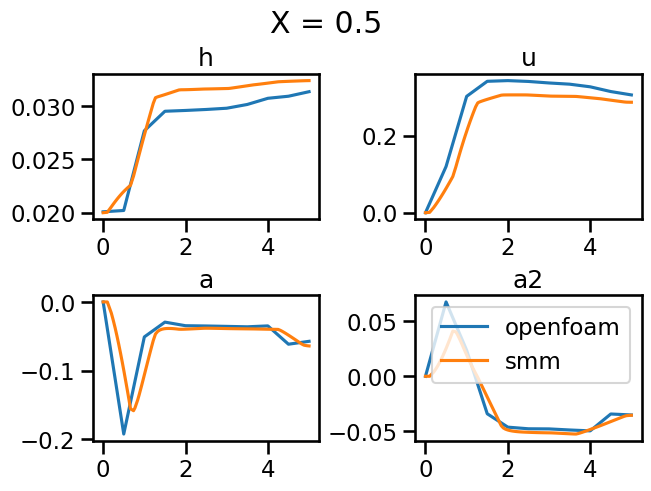

In [83]:

x_smm, Q_smm, Qaux_smm, timeline_smm = io.load_timeline_of_fields_from_hdf5(os.path.join(settings.output_dir, "ShallowMoments.h5" ))
i_pos = ((x_smm-pos)**2).argmin()
h_smm = Q_smm[:, 0, i_pos]
u_smm = Q_smm[:, 1, i_pos]/h_smm
try:
    a_smm = Q_smm[:, 2, i_pos]/h_smm
except:
    a_smm = np.zeros_like(h_smm)
try:
    a2_smm = Q_smm[:, 3, i_pos]/h_smm
except:
    a2_smm = np.zeros_like(h_smm)

fig, ax = plt.subplots(2, 2, constrained_layout=True)
ax[0, 0].plot(timeline_openfoam, h_openfoam, label='openfoam')
ax[0, 0].plot(timeline_smm, h_smm, label='smm')
ax[0, 0].set_title('h')
ax[0, 1].plot(timeline_openfoam, mom_u_openfoam, label='openfoam')
ax[0, 1].plot(timeline_smm, u_smm, label='smm')
ax[0, 1].set_title('u')
ax[1, 0].plot(timeline_openfoam, mom_a_openfoam, label='openfoam')
ax[1, 0].plot(timeline_smm, a_smm, label='smm')
ax[1, 0].set_title('a')
ax[1, 1].plot(timeline_openfoam, mom_a2_openfoam, label='openfoam')
ax[1, 1].plot(timeline_smm, a2_smm, label='smm')
ax[1, 1].set_title('a2')
plt.suptitle(f"X = {pos}")
plt.legend()
fig.savefig("images/comp05.png")

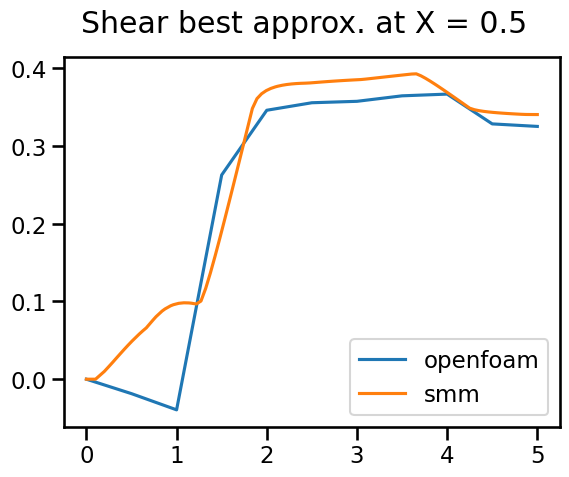

In [84]:
shear_openfoam = shear_at_bottom_moments(moments_openfoam[:, :level+1])
moments_smm = Q_smm[:, 1:, i_pos]/np.repeat(h_smm, Q_smm.shape[1]-1).reshape((Q_smm.shape[0], Q_smm.shape[1]-1))
shear_smm = shear_at_bottom_moments(moments_smm)
fig, ax = plt.subplots()
ax.plot(timeline_openfoam, shear_openfoam, label='openfoam')
ax.plot(timeline_smm, shear_smm, label='smm')
plt.suptitle(f"Shear best approx. at X = {pos}")
plt.legend()
fig.savefig("images/shear_ba_05.png")

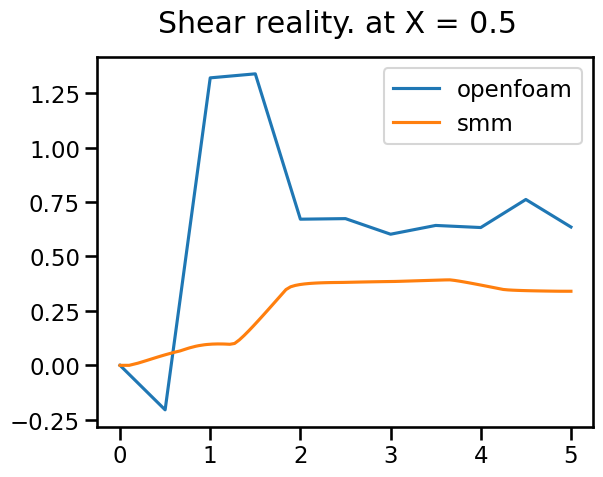

In [85]:
shear_openfoam = shear_at_bottom_moments(moments_openfoam[:, :10])
moments_smm = Q_smm[:, 1:, i_pos]/np.repeat(h_smm, Q_smm.shape[1]-1).reshape((Q_smm.shape[0], Q_smm.shape[1]-1))
shear_smm = shear_at_bottom_moments(moments_smm)
fig, ax = plt.subplots()
ax.plot(timeline_openfoam, shear_openfoam, label='openfoam')
ax.plot(timeline_smm, shear_smm, label='smm')
plt.suptitle(f"Shear reality. at X = {pos}")
plt.legend()
fig.savefig("images/shear_real_05.png")

In [86]:
pos = 1.2
# h_openfoam = experiments[str(pos)]["h"]
# timeline_openfoam = experiments[str(pos)]["timeline"]
h_openfoam, moments_openfoam, moments_w_openfoam, timeline_openfoam, u_openfoam, w_openfoam = project_openfoam_to_smm(directory, pos=[pos, 0, 0], stride=50, output_uw = True)
mom_u_openfoam = moments_openfoam[:, 0]
mom_a_openfoam = moments_openfoam[:, 1]
mom_a2_openfoam = moments_openfoam[:, 2]


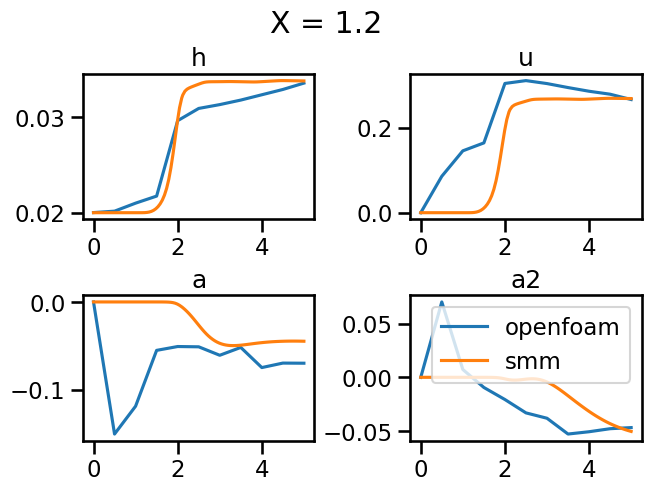

In [87]:
x_smm, Q_smm, Qaux_smm, timeline_smm = io.load_timeline_of_fields_from_hdf5(os.path.join(settings.output_dir, "ShallowMoments.h5" ))
i_pos = ((x_smm-pos)**2).argmin()
h_smm = Q_smm[:, 0, i_pos]
u_smm = Q_smm[:, 1, i_pos]/h_smm
try:
    a_smm = Q_smm[:, 2, i_pos]/h_smm
except:
    a_smm = np.zeros_like(h_smm)
try:
    a2_smm = Q_smm[:, 3, i_pos]/h_smm
except:
    a2_smm = np.zeros_like(h_smm)


fig, ax = plt.subplots(2, 2, constrained_layout=True)
ax[0, 0].plot(timeline_openfoam, h_openfoam, label='openfoam')
ax[0, 0].plot(timeline_smm, h_smm, label='smm')
ax[0, 0].set_title('h')
ax[0, 1].plot(timeline_openfoam, mom_u_openfoam, label='openfoam')
ax[0, 1].plot(timeline_smm, u_smm, label='smm')
ax[0, 1].set_title('u')
ax[1, 0].plot(timeline_openfoam, mom_a_openfoam, label='openfoam')
ax[1, 0].plot(timeline_smm, a_smm, label='smm')
ax[1, 0].set_title('a')
ax[1, 1].plot(timeline_openfoam, mom_a2_openfoam, label='openfoam')
ax[1, 1].plot(timeline_smm, a2_smm, label='smm')
ax[1, 1].set_title('a2')
plt.suptitle(f"X = {pos}")
plt.legend()
fig.savefig("images/comp12.png")

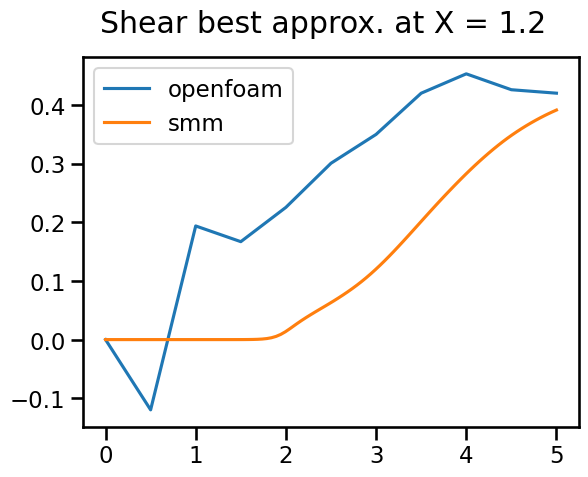

In [88]:

shear_openfoam = shear_at_bottom_moments(moments_openfoam[:, :level+1])
moments_smm = Q_smm[:, 1:, i_pos]/np.repeat(h_smm, Q_smm.shape[1]-1).reshape((Q_smm.shape[0], Q_smm.shape[1]-1))
shear_smm = shear_at_bottom_moments(moments_smm)
fig, ax = plt.subplots()
ax.plot(timeline_openfoam, shear_openfoam, label='openfoam')
ax.plot(timeline_smm, shear_smm, label='smm')
plt.suptitle(f"Shear best approx. at X = {pos}")
plt.legend()
fig.savefig("images/shear_ba_12.png")


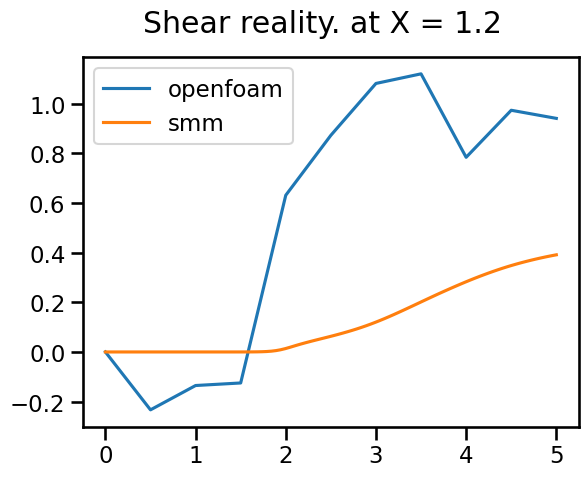

In [89]:

shear_openfoam = shear_at_bottom_moments(moments_openfoam[:, :10])
moments_smm = Q_smm[:, 1:, i_pos]/np.repeat(h_smm, Q_smm.shape[1]-1).reshape((Q_smm.shape[0], Q_smm.shape[1]-1))
shear_smm = shear_at_bottom_moments(moments_smm)
fig, ax = plt.subplots()
ax.plot(timeline_openfoam, shear_openfoam, label='openfoam')
ax.plot(timeline_smm, shear_smm, label='smm')
plt.suptitle(f"Shear reality. at X = {pos}")
plt.legend()
fig.savefig("images/shear_real_12.png")

In [90]:
pos = 2.5
# h_openfoam = experiments[str(pos)]["h"]
# timeline_openfoam = experiments[str(pos)]["timeline"]
h_openfoam, moments_openfoam, moments_w_openfoam, timeline_openfoam, u_openfoam, w_openfoam = project_openfoam_to_smm(directory, pos=[pos, 0, 0], stride=50, output_uw = True)
mom_u_openfoam = moments_openfoam[:, 0]
mom_a_openfoam = moments_openfoam[:, 1]
mom_a2_openfoam = moments_openfoam[:, 2]



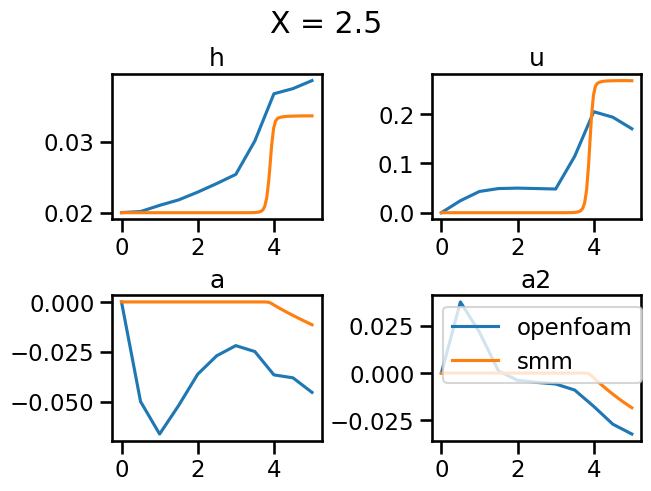

In [91]:
x_smm, Q_smm, Qaux_smm, timeline_smm = io.load_timeline_of_fields_from_hdf5(os.path.join(settings.output_dir, "ShallowMoments.h5" ))
i_pos = ((x_smm-pos)**2).argmin()
h_smm = Q_smm[:, 0, i_pos]
u_smm = Q_smm[:, 1, i_pos]/h_smm
try:
    a_smm = Q_smm[:, 2, i_pos]/h_smm
except:
    a_smm = np.zeros_like(h_smm)
try:
    a2_smm = Q_smm[:, 3, i_pos]/h_smm
except:
    a2_smm = np.zeros_like(h_smm)

fig, ax = plt.subplots(2, 2, constrained_layout=True)
ax[0, 0].plot(timeline_openfoam, h_openfoam, label='openfoam')
ax[0, 0].plot(timeline_smm, h_smm, label='smm')
ax[0, 0].set_title('h')
ax[0, 1].plot(timeline_openfoam, mom_u_openfoam, label='openfoam')
ax[0, 1].plot(timeline_smm, u_smm, label='smm')
ax[0, 1].set_title('u')
ax[1, 0].plot(timeline_openfoam, mom_a_openfoam, label='openfoam')
ax[1, 0].plot(timeline_smm, a_smm, label='smm')
ax[1, 0].set_title('a')
ax[1, 1].plot(timeline_openfoam, mom_a2_openfoam, label='openfoam')
ax[1, 1].plot(timeline_smm, a2_smm, label='smm')
ax[1, 1].set_title('a2')
plt.suptitle(f"X = {pos}")
plt.legend()
fig.savefig("images/comp25.png")

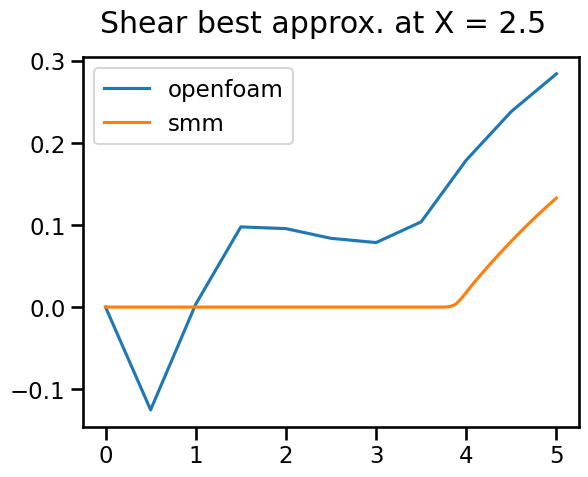

In [92]:


shear_openfoam = shear_at_bottom_moments(moments_openfoam[:, :level+1])
moments_smm = Q_smm[:, 1:, i_pos]/np.repeat(h_smm, Q_smm.shape[1]-1).reshape((Q_smm.shape[0], Q_smm.shape[1]-1))
shear_smm = shear_at_bottom_moments(moments_smm)
fig, ax = plt.subplots()
ax.plot(timeline_openfoam, shear_openfoam, label='openfoam')
ax.plot(timeline_smm, shear_smm, label='smm')
plt.suptitle(f"Shear best approx. at X = {pos}")
plt.legend()
fig.savefig("images/shear_ba_25.png")


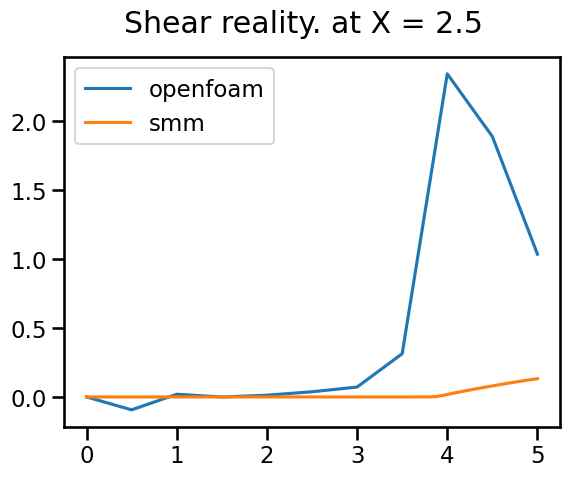

In [93]:

shear_openfoam = shear_at_bottom_moments(moments_openfoam[:, :10])
moments_smm = Q_smm[:, 1:, i_pos]/np.repeat(h_smm, Q_smm.shape[1]-1).reshape((Q_smm.shape[0], Q_smm.shape[1]-1))
shear_smm = shear_at_bottom_moments(moments_smm)
fig, ax = plt.subplots()
ax.plot(timeline_openfoam, shear_openfoam, label='openfoam')
ax.plot(timeline_smm, shear_smm, label='smm')
plt.suptitle(f"Shear reality. at X = {pos}")
plt.legend()
fig.savefig("images/shear_real_25.png")